<a href="https://colab.research.google.com/github/boyiliu1007/recourse-experiment/blob/main/demo2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from copy import deepcopy
from dataclasses import dataclass
from typing import Literal

import numpy as np
from numpy.typing import NDArray

import sklearn as skl
import torch as pt

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns


sns.set_theme(style='darkgrid', palette='muted')

In [2]:
from sklearn.datasets import make_classification

from torch.utils import data


@dataclass(slots=True)
class Dataset(data.Dataset):
    x: pt.Tensor
    y: pt.Tensor

    def __len__(self):
        # return the number of samples in the dataset
        return len(self.x)

    def __getitem__(self, index):
        # return the certain sample and label according to index
        return self.x[index], self.y[index]

    def __iter__(self):
        # return the certain sample and label according to index
        return zip(self.x, self.y)

    def __len__(self):
        return self.x.shape[0]

    def __repr__(self):
        return f'{type(self)}({self.x.shape})'


def make_dataset(train: int, test: int, sample: int):
    n_samples = train + test + sample # Calculate the total number of samples
    x, y = make_classification(n_samples, random_state=42) # Generate synthetic data using scikit-learn's make_classification

    # Convert data to PyTorch tensors
    x = pt.tensor(x, dtype=pt.float)
    y = pt.tensor(y[..., None], dtype=pt.float) # Add a dimension to y

    # Define slices for training, testing, and sample subsets
    # These lines define slices (np.s_) for selecting subsets of data.
    i_train = np.s_[:train]
    i_test = np.s_[train:train+test]
    i_sample = np.s_[train+test:]

    # Create Dataset objects for training, testing, and sample subsets
    d_train = Dataset(x[i_train], y[i_train])
    d_test = Dataset(x[i_test], y[i_test])
    d_sample = Dataset(x[i_sample], y[i_sample])

    return d_train, d_test, d_sample


# Create a synthetic dataset with 100 train, 100 test, and 2000 sample
train, test, sample = make_dataset(100, 100, 2000)

In [3]:
from torch import nn, optim

# This is a two-layer model doing regression
class LogisticRegression(nn.Module):
    def __init__(self, input_dim: int, output_dim: int):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.linear(x)
        x = self.sigmoid(x)
        # Return the output of this two layers model
        return x

#  It takes the number of input features (train.x.shape[1]) and the output dimension (1)
model = LogisticRegression(train.x.shape[1], 1)
loss_list = []
acc_list = []

In [4]:
def calculate_accuracy(predicted_results, actual_labels, threshold=0.5):
    # Convert probabilities to binary predictions based on the threshold
    binary_predictions = []
    for prob in predicted_results:
      pred_label = 0
      if prob >= threshold:
        pred_label = 1
      else:
        pred_label = 0
      binary_predictions.append(pred_label)

    # Compare binary predictions to actual labels
    correct_predictions = []
    for i in range(0, len(binary_predictions)):
      if(binary_predictions[i] == actual_labels[i]):
        correct_predictions.append(1)
      else:
        correct_predictions.append(0)

    # Calculate accuracy as the ratio of correct predictions to total predictions
    if len(correct_predictions) == 0:
      return 0
    accuracy = sum(correct_predictions) / len(correct_predictions)
    return accuracy

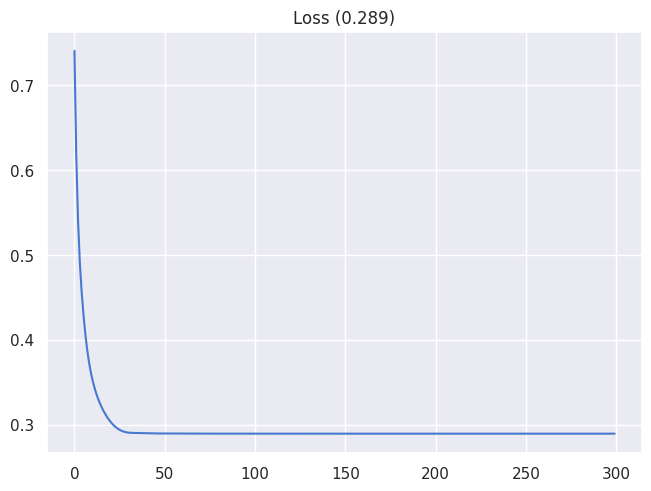

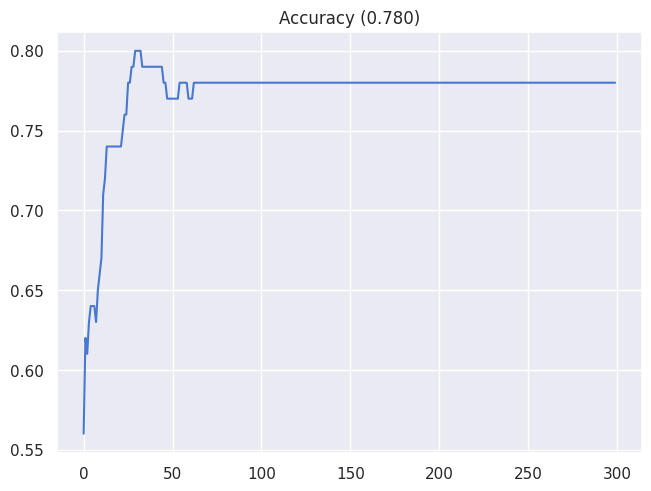

In [5]:
def draw_statistic(*args, mode: Literal['both', 'loss', 'acc'] = 'loss', title = "Accuracy"):

    # Matplotlib Objects
    fig: plt.Figure
    ax: plt.Axes
    ax0: plt.Axes
    ax1: plt.Axes

    # handle the mode for each drawing
    # TODO: fix the drawing
    if mode == 'both':
        fig, (ax0, ax1) = plt.subplots(
            1, 2,
            sharex=True,
            figsize=(10, 5),
            layout='constrained'
        )
        ax0.plot(args[0], c='C0')
        ax1.plot(args[1], c='C1')
        ax0.set_title(f'Loss ({args[0][-1]:.3f})')
        ax1.set_title(f'Accuracy ({args[1][-1]:.1%})')
    elif mode == 'loss':
        fig, ax = plt.subplots(1, 1, layout='constrained')
        ax.plot(args[0])
        ax.set_title(f'Loss ({args[0][-1]:.3f})')
    elif mode == 'acc':
        fig, ax = plt.subplots(1, 1, layout='constrained')
        ax.plot(args[0])
        ax.set_title(f'{title} ({args[0][-1]:.3f})')

    else:
        raise ValueError('mode must be one of both, loss, or acc')


def training(model: nn.Module, dataset: Dataset, max_epochs: int, loss_list: list | None = None, acc_list: list | None = None, testDataset: Dataset | None = None):
    # loss_list, acc_list could be a list or None. By default it is None.

    loss: pt.Tensor
    criterion = nn.BCELoss() # Binary Cross Entropy (BCE) loss function
    # This loss function is commonly used for binary classification problems.

    optimizer = optim.Adam(model.parameters(), 0.1) #The learning rate is set to 0.3.
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer) #adjusts the learning rate during training based on the validation loss.
    model.train()


    for _ in range(max_epochs):
        outputs = model(dataset.x)

        #Calculates the loss by comparing the predicted outputs (outputs) with the ground truth labels (dataset.y) using the BCE loss.
        loss = criterion(outputs, dataset.y)
        loss.backward()
        optimizer.step() # Updates the model parameters
        optimizer.zero_grad() # Clears the gradients.
        scheduler.step(loss) # Adjusts the learning rate based on the computed loss.
        if loss_list is not None:
          loss_list.append(loss.item())
        if acc_list is not None:
          if testDataset is None:
            acc_list.append(calculate_accuracy(model(test.x), test.y))
          else:
            acc_list.append(calculate_accuracy(model(testDataset.x), testDataset.y))
    model.eval()


training(model, train, 300, loss_list, acc_list)
draw_statistic(loss_list, mode='loss')
draw_statistic(acc_list, mode='acc')

In [6]:
class Recourse(nn.Module):
    def __init__(self, size):
        super().__init__()
        self.action = nn.Parameter(pt.zeros(size))
        # Creates a learnable parameter named action using nn.Parameter.
        # The parameter is initialized with a tensor of zeros (pt.zeros(size)), and its size is determined by the input argument size.

    def forward(self, x: pt.Tensor, weight: pt.Tensor | None = None):
        # ?
        a = self.action
        if weight is not None:
            a = a * weight
        x = x + a
        return x


def recourse(c_model: nn.Module, dataset: Dataset, max_epochs: int, weight: pt.Tensor | None = None, loss_list: list | None = None):
    loss: pt.Tensor
    r_model = Recourse(dataset.x.shape)
    criterion = nn.HuberLoss() # This loss function is often used for robust regression.
    optimizer = optim.Adam(r_model.parameters(), 0.1)
    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

    r_model.train()
    for _ in range(max_epochs):
        # ?
        x_hat = r_model(dataset.x, weight) #no weight?
        y_hat = c_model(x_hat)

        loss = criterion(y_hat, dataset.y)#+lmd*(x_hat-dataset.x)*weight
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        c_model.zero_grad()
        # scheduler.step(loss)
        if loss_list is not None:
            loss_list.append(loss.item())
            # ?
            print(loss_list)
    r_model.eval()

    with pt.no_grad():
        dataset.x = r_model(dataset.x)


In [7]:
from sklearn.decomposition import PCA

pca = PCA(2).fit(train.x)

In [8]:
from matplotlib.animation import FuncAnimation
from matplotlib.axes import Axes
from matplotlib.figure import Figure, SubFigure
from matplotlib.colors import ListedColormap
from matplotlib.collections import PathCollection
from matplotlib.container import BarContainer
from matplotlib.contour import QuadContourSet
from matplotlib.patches import Rectangle


class PlotHelper:

    palette = sns.color_palette('muted', 2)
    cmap = ListedColormap(palette)

    def __init__(self, model: nn.Module, pca: PCA, train: Dataset, test: Dataset, sample: Dataset):
        self.model = model
        self.pca = pca
        self.train = train
        self.test = test
        self.sample = sample

        self._hist: list[BarContainer]
        self._bins: NDArray
        self._sc_train: PathCollection
        self._sc_test: PathCollection
        self._ct_test: QuadContourSet

    def draw_proba_hist(self, ax: Axes | None = None, *, label: bool = False):
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 4))
        else:
            fig = ax.get_figure()

        x = self.test.x
        y = self.test.y

        n = x.shape[0]
        m = n - pt.count_nonzero(y)

        with pt.no_grad():
            y_prob: pt.Tensor = self.model(x)

        y = y.flatten()
        y_prob = y_prob.flatten()
        y_prob = y_prob[y.argsort()]

        w = np.broadcast_to(100 / n, n)

        self._hist: list[BarContainer]
        _, self._bins, self._hist = ax.hist(
            (y_prob[:m], y_prob[m:]),
            10,
            (0, 1),
            weights=(w[:m], w[m:]),
            rwidth=1,
            color=self.palette,
            label=(0, 1),
            ec='w',
            alpha=0.9,
        )

        ax.legend(loc='upper center', title='True label')
        ax.set_xlabel('mean predicted probabilty')
        ax.set_ylabel('percent')
        ax.set_title('Probability Distribution')

        if label:
            for c in self._hist:
                height = map(Rectangle.get_height, c.patches)
                ax.bar_label(
                    c,
                    [f'{h}%' if h else '' for h in height],
                    fontsize='xx-small'
                )
        return fig, ax

    def draw_dataset_scatter(self, axes: tuple[Axes, Axes] | None = None):
        if axes is None:
            fig, (ax0, ax1) = plt.subplots(
                1, 2,
                sharex=True,
                sharey=True,
                figsize=(8, 4),
                layout='compressed'
            )
        else:
            ax0, ax1 = axes
            fig = ax0.get_figure()

        prop = dict(cmap=self.cmap, s=40, vmin=0., vmax=1., lw=0.8, ec='w')

        self._sc_train = ax0.scatter(
            *pca.transform(self.train.x).T,
            c=self.train.y,
            **prop
        )
        ax0.legend(
            *self._sc_train.legend_elements(),
            loc='upper right',
            title='True label'
        )
        ax0.set_xlabel('pca0')
        ax0.set_ylabel('pca1')
        ax0.set_title('Train')

        with pt.no_grad():
            y_prob: pt.Tensor = self.model(test.x)

        y_prob = y_prob.flatten()
        y_pred = y_prob.greater(0.5)

        self._sc_test = ax1.scatter(
            *pca.transform(test.x).T,
            c=y_pred,
            **prop
        )
        ax1.legend(
            *self._sc_test.legend_elements(),
            loc='upper right',
            title='Predicted'
        )

        x0, x1 = ax0.get_xlim()
        y0, y1 = ax0.get_ylim()
        n = 32
        xy = np.mgrid[x0: x1: n * 1j, y0: y1: n * 1j]
        z = pca.inverse_transform(xy.reshape(2, n * n).T)

        z = pt.tensor(z, dtype=pt.float)
        with pt.no_grad():
            z: pt.Tensor = self.model(z)
        z = z.view(n, n)
        self._ct_test = ax1.contourf(
            *xy, z, 10,
            cmap='RdYlBu_r',
            vmin=0,
            vmax=1,
            alpha=0.9,
            zorder=0,
        )
        fig.colorbar(self._ct_test, ax=ax1, label='probability')
        ax1.grid(alpha=0.75)
        ax1.set_xlabel('pca0')
        ax1.set_title('Test')

        return fig, axes

    def draw_all(self):
        sf: list[SubFigure]
        fig = plt.figure(figsize=(8, 8), layout='constrained')
        sf = fig.subfigures(2, 1)
        ax0 = sf[0].subplots()
        ax1, ax2 = sf[1].subplots(1, 2, sharex=True, sharey=True)
        self.draw_proba_hist(ax0)
        self.draw_dataset_scatter((ax1, ax2))
        return fig, (ax0, ax1, ax2)

    def animate_all(self, frames: int = 120, fps: int = 10, *, inplace: bool = False):
        fig, (ax0, ax1, ax2) = self.draw_all()

        model = self.model if inplace else deepcopy(self.model)
        train = self.train if inplace else deepcopy(self.train)
        test = self.test
        sample = self.sample

        def init():
            return *ax0.patches, *ax1.collections, *ax2.collections

        def func(frame):
            fig.suptitle(f'No. {frame}', ha='left', x=0.01, size='small')

            if frame == 0:
                return ()

            self.update(model, train, sample)

            y = test.y.flatten()

            n = test.x.shape[0]
            m = n - pt.count_nonzero(y)

            with pt.no_grad():
                y_prob: pt.Tensor = model(test.x)

            y_prob = y_prob.flatten()
            y_pred = y_prob.greater(0.5)
            rank = y_prob[y.argsort()]

            for b, r in zip(self._hist, (rank[:m], rank[m:])):
                height, _ = np.histogram(r, self._bins)
                for r, h in zip(b.patches, height * (100 / n)):
                    r.set_height(h)

            self._sc_train.set_offsets(pca.transform(train.x))
            self._sc_train.set_array(train.y.flatten())
            self._sc_test.set_array(y_pred)

            ax1.relim()
            ax1.autoscale_view()

            for c in self._ct_test.collections:
                c.remove()

            x0, x1 = ax1.get_xlim()
            y0, y1 = ax1.get_ylim()
            n = 32
            xy = np.mgrid[x0: x1: n * 1j, y0: y1: n * 1j]
            z = pca.inverse_transform(xy.reshape(2, n * n).T)
            z = pt.tensor(z, dtype=pt.float)
            with pt.no_grad():
                z: pt.Tensor = model(z)
            z = z.view(n, n)

            self._ct_test: QuadContourSet = ax2.contourf(
                *xy, z, 10,
                cmap='RdYlBu_r',
                vmin=0,
                vmax=1,
                alpha=0.9,
                zorder=0,
            )

            return *ax0.patches, *ax1.collections, *ax2.collections

        return FuncAnimation(
            fig, func, frames, init,
            interval=1000 // fps,
            repeat=False,
            blit=True,
            cache_frame_data=False
        )

    def update(self, model: nn.Module, train: Dataset, sample: Dataset):
        raise NotImplementedError()


# helper = PlotHelper(model, pca, train, test, sample)
# helper.draw_all()
# plt.show()

In [18]:
def calculate_AA(kth_model: nn.Module, jth_data_after_recourse: list):
  if jth_data_after_recourse:
    kth_model.eval()
    sum = 0

    # do each historical task
    for j in jth_data_after_recourse:
      pred = kth_model(j.x)
      acc = calculate_accuracy(pred, j.y)
      sum += acc

    return sum / len(jth_data_after_recourse)

  print("jth_data_after_recourse cannot be empty")
  return None

def calculate_BWT(kth_model: nn.Module, jth_data_after_recourse, Ajj_performance_list):
  kth_model.eval()
  sum = 0

  for i in range (0, len(jth_data_after_recourse)):
    # if is the last loop, calculate A(j,j) and store it
    if i == len(jth_data_after_recourse) - 1:
      pred = kth_model(jth_data_after_recourse[i].x)
      Ajj_performance_list.append(calculate_accuracy(pred, jth_data_after_recourse[-1].y))
    # else we calculate A(k,j) - A(j,j)
    else:
      pred = kth_model(jth_data_after_recourse[i].x)
      acc = calculate_accuracy(pred, jth_data_after_recourse[i].y) - Ajj_performance_list[i]
      sum += acc

  if len(jth_data_after_recourse) == 1:
    return sum
  return sum / (len(jth_data_after_recourse) - 1)

def calculate_FWT(Ajj_performance_list, Aj_tide_list):
  sum = 0

  for i in range(1, len(Ajj_performance_list)):
    sum +=  Ajj_performance_list[i] - Aj_tide_list[i]
    print(Ajj_performance_list[i], Aj_tide_list[i])
  if len(Aj_tide_list) == 1:
    return sum
  return sum / (len(Aj_tide_list) - 1)

validation_list = []
Ajj_performance_list = []
overall_acc_list = []
memory_stability_list = []
memory_plasticity_list = []
Aj_tide_list = []

1.0 1.0
1.0 1.0
0.9 1.0
1.0 1.0
0.9 1.0
0.9 1.0
1.0 1.0
0.9 1.0
0.9 1.0
0.9 1.0
1.0 1.0
0.9 1.0
0.9 1.0
0.9 1.0
0.9 1.0
1.0 1.0
0.9 1.0
0.9 1.0
0.9 1.0
0.9 1.0
0.8 1.0
1.0 1.0
0.9 1.0
0.9 1.0
0.9 1.0
0.9 1.0
0.8 1.0
0.8 1.0
1.0 1.0
0.9 1.0
0.9 1.0
0.9 1.0
0.9 1.0
0.8 1.0
0.8 1.0
0.9 1.0
1.0 1.0
0.9 1.0
0.9 1.0
0.9 1.0
0.9 1.0
0.8 1.0
0.8 1.0
0.9 1.0
1.0 1.0
1.0 1.0
0.9 1.0
0.9 1.0
0.9 1.0
0.9 1.0
0.8 1.0
0.8 1.0
0.9 1.0
1.0 1.0
0.9 1.0
1.0 1.0
0.9 1.0
0.9 1.0
0.9 1.0
0.9 1.0
0.8 1.0
0.8 1.0
0.9 1.0
1.0 1.0
0.9 1.0
0.9 1.0
1.0 1.0
0.9 1.0
0.9 1.0
0.9 1.0
0.9 1.0
0.8 1.0
0.8 1.0
0.9 1.0
1.0 1.0
0.9 1.0
0.9 1.0
0.9 1.0
1.0 1.0
0.9 1.0
0.9 1.0
0.9 1.0
0.9 1.0
0.8 1.0
0.8 1.0
0.9 1.0
1.0 1.0
0.9 1.0
0.9 1.0
0.9 1.0
0.8 1.0
1.0 1.0
0.9 1.0
0.9 1.0
0.9 1.0
0.9 1.0
0.8 1.0
0.8 1.0
0.9 1.0
1.0 1.0
0.9 1.0
0.9 1.0
0.9 1.0
0.8 1.0
0.7 1.0
1.0 1.0
0.9 1.0
0.9 1.0
0.9 1.0
0.9 1.0
0.8 1.0
0.8 1.0
0.9 1.0
1.0 1.0
0.9 1.0
0.9 1.0
0.9 1.0
0.8 1.0
0.7 1.0
0.9 1.0
1.0 1.0
0.9 1.0
0.9 1.0
0.9 1.0
0.9 1.0


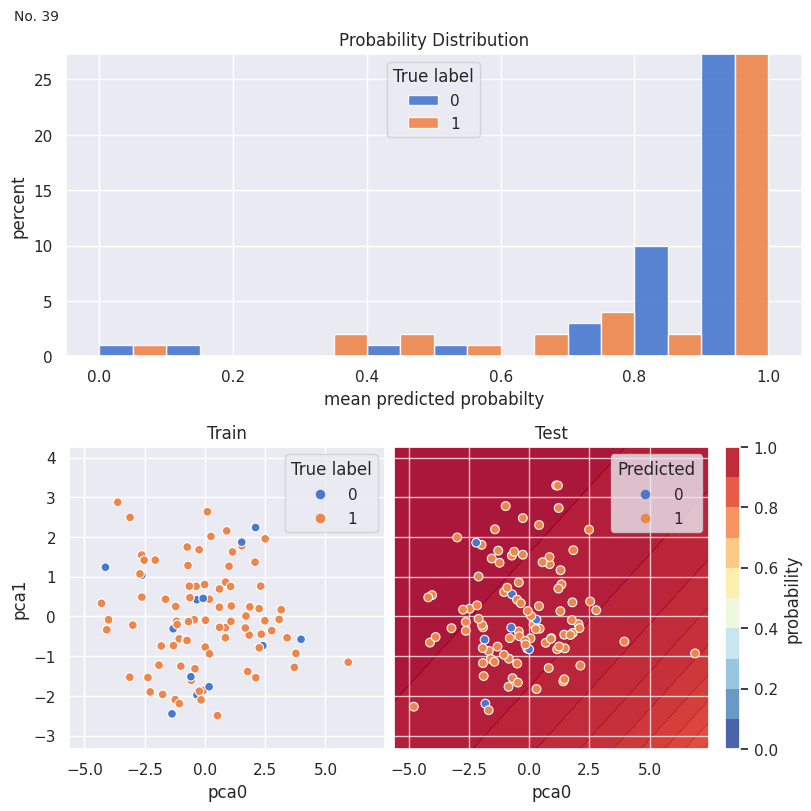

In [10]:
class Example1(PlotHelper):
    '''
    Update Method Steps:
    1. Selects a random subset of `sample` with a approximately size of `train.size * 1/4`.
    2. Performs recourse on the selected subset of 'sample' while preserving their original labels.
    3. Replaces a corresponding part of the training set with the updated samples.
    4. Refits the model with the modified training data.
    '''

    def update(self, model: nn.Module, train: Dataset, sample: Dataset):
        # sample is used for recourse training and train is used for main model triaing

        # sample size
        size = train.x.shape[0] // 10
        i = np.random.choice(sample.x.shape[0], size, False)
        x = sample.x[i]

        # find out some data whose label is 0 in sample to concatenate 1's data and 0's data
        sample_y_zero = np.where(sample.y == 0)[0]
        sample_0_indices = np.random.choice(sample_y_zero, size=size, replace=False)

        #  Computes the model's predicted probabilities
        with pt.no_grad():
            y_prob: pt.Tensor = model(x)

        y_pred = y_prob.flatten() < 0.5 # a True or False list
        # Creates a new dataset (sub_sample) containing only the samples for which the model predicted a label of 0.
        # The labels for these data are set to 1 in the new dataset.
        sub_sample = Dataset(x[y_pred], pt.ones((y_pred.count_nonzero(), 1)))

        recourse(model, sub_sample, 50)

        # x[y_pred] selects the elements from x where the corresponding value in y_pred is True.
        # The selected elements are then replaced with the values from sub_sample.x.
        x[y_pred] = sub_sample.x

        j = np.random.choice(train.x.shape[0], size, False)
        train.x[j] = x

        # reserve original label
        train.y[j, 0] = (~y_pred).float()

        val_data = Dataset(train.x[j], train.y[j])
        validation_list.append(val_data)
        sample_model = LogisticRegression(val_data.x.shape[1], 1)
        sample_model.train()
        training(sample_model, val_data, 30)
        Aj_tide_list.append(calculate_accuracy(sample_model(val_data.x), val_data.y))

        model.train()
        training(model, train, 30)

        # calculate the overall accuracy
        overall_acc_list.append(calculate_AA(model, validation_list))

        # evaluate memory stability
        memory_stability_list.append(calculate_BWT(model, validation_list, Ajj_performance_list))

        # evaluate memory plasticity
        memory_plasticity_list.append(calculate_FWT(Ajj_performance_list, Aj_tide_list))

ex1 = Example1(model, pca, train, test, sample)
ani1 = ex1.animate_all(40)
ani1.save('output/ex1.gif')

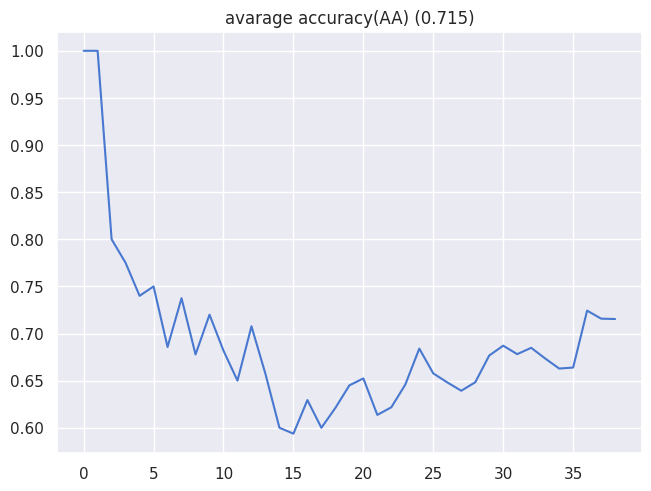

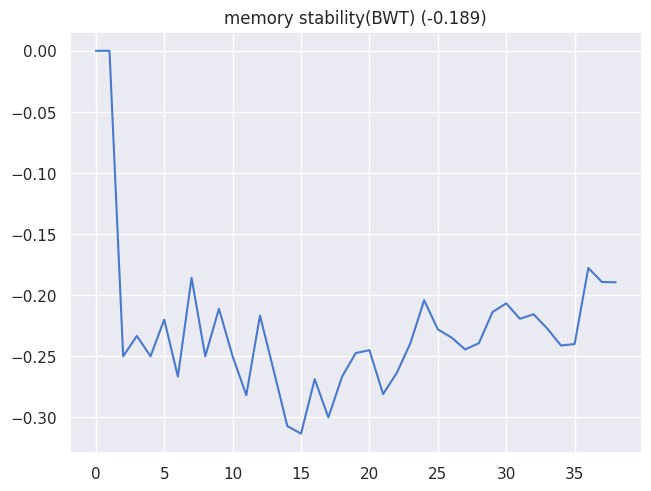

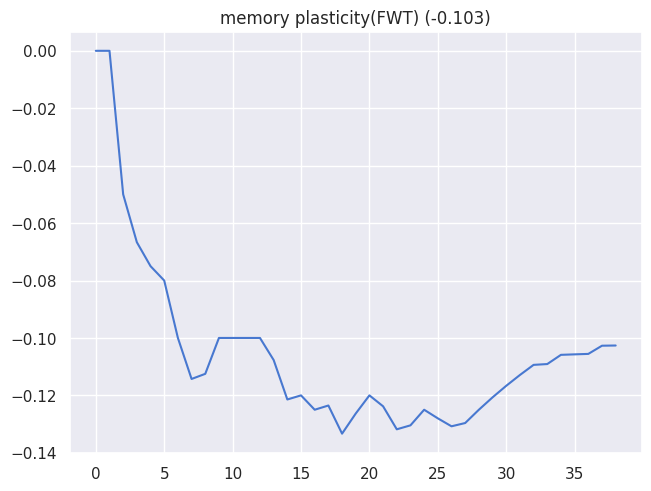

In [11]:
draw_statistic(overall_acc_list, mode='acc', title = "avarage accuracy(AA)")
draw_statistic(memory_stability_list, mode='acc', title = "memory stability(BWT)")
draw_statistic(memory_plasticity_list, mode='acc', title = "memory plasticity(FWT)")

0.8 1.0
0.8 1.0
0.6 1.0
0.8 1.0
0.6 1.0
0.9 1.0
0.8 1.0
0.6 1.0
0.9 1.0
0.7 1.0
0.8 1.0
0.6 1.0
0.9 1.0
0.7 1.0
0.9 1.0
0.8 1.0
0.6 1.0
0.9 1.0
0.7 1.0
0.9 1.0
0.7 1.0
0.8 1.0
0.6 1.0
0.9 1.0
0.7 1.0
0.9 1.0
0.7 1.0
0.5 1.0
0.8 1.0
0.6 1.0
0.9 1.0
0.7 1.0
0.9 1.0
0.7 1.0
0.5 1.0
0.9 1.0
0.8 1.0
0.6 1.0
0.9 1.0
0.7 1.0
0.9 1.0
0.7 1.0
0.5 1.0
0.9 1.0
0.8 1.0
0.8 1.0
0.6 1.0
0.9 1.0
0.7 1.0
0.9 1.0
0.7 1.0
0.5 1.0
0.9 1.0
0.8 1.0
0.4 1.0
0.8 1.0
0.6 1.0
0.9 1.0
0.7 1.0
0.9 1.0
0.7 1.0
0.5 1.0
0.9 1.0
0.8 1.0
0.4 1.0
0.8 1.0
0.8 1.0
0.6 1.0
0.9 1.0
0.7 1.0
0.9 1.0
0.7 1.0
0.5 1.0
0.9 1.0
0.8 1.0
0.4 1.0
0.8 1.0
0.9 1.0
0.8 1.0
0.6 1.0
0.9 1.0
0.7 1.0
0.9 1.0
0.7 1.0
0.5 1.0
0.9 1.0
0.8 1.0
0.4 1.0
0.8 1.0
0.9 1.0
0.8 1.0
0.8 1.0
0.6 1.0
0.9 1.0
0.7 1.0
0.9 1.0
0.7 1.0
0.5 1.0
0.9 1.0
0.8 1.0
0.4 1.0
0.8 1.0
0.9 1.0
0.8 1.0
0.9 1.0
0.8 1.0
0.6 1.0
0.9 1.0
0.7 1.0
0.9 1.0
0.7 1.0
0.5 1.0
0.9 1.0
0.8 1.0
0.4 1.0
0.8 1.0
0.9 1.0
0.8 1.0
0.9 1.0
0.8 1.0
0.8 1.0
0.6 1.0
0.9 1.0
0.7 1.0
0.9 1.0


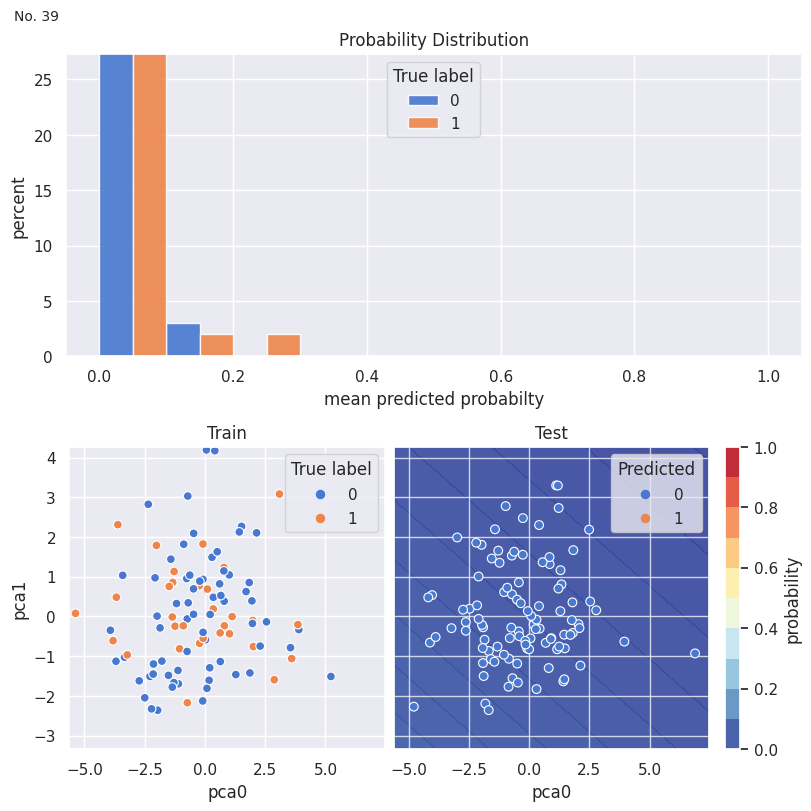

In [15]:
class Example5(PlotHelper):
    '''
    Update Method Steps:
    1. Selects a random subset of `sample` with a size of `train.size * 0.1`.
    2. Performs recourse on the selected samples.
    3. Randomly relabels samples based on the model's probability scores.
    4. Replaces a corresponding part of the training set with the updated samples.
    5. Refits the model with the modified training data.
    '''
    def update(self, model: nn.Module, train: Dataset, sample: Dataset):
        # sample is used for recourse training and train is used for main model triaing

        # sample size
        size = train.x.shape[0] // 10
        i = np.random.choice(sample.x.shape[0], size, False)
        x = sample.x[i]

        # find out some data whose label is 0 in sample to concatenate 1's data and 0's data
        sample_y_zero = np.where(sample.y == 0)[0]
        sample_0_indices = np.random.choice(sample_y_zero, size=size, replace=False)

        with pt.no_grad():
            y_prob: pt.Tensor = model(x)

        y_pred = y_prob.flatten() < 0.5
        sub_sample = Dataset(x[y_pred], pt.full((y_pred.count_nonzero(), 1), 0.6))

        recourse(model, sub_sample, 5)

        x[y_pred] = sub_sample.x

        j = np.random.choice(train.x.shape[0], size, False)

        with pt.no_grad():
            y_prob: pt.Tensor = model(x)

        #randomly relabel
        train.x[j] = x
        train.y[j] = (pt.rand_like(y_prob) > y_prob).float()

        val_data = Dataset(train.x[j], train.y[j])
        validation_list.append(val_data)
        sample_model = LogisticRegression(val_data.x.shape[1], 1)
        sample_model.train()
        training(sample_model, val_data, 40)
        Aj_tide_list.append(calculate_accuracy(sample_model(val_data.x), val_data.y))

        model.train()
        training(model, train, 30)

        # calculate the overall accuracy
        overall_acc_list.append(calculate_AA(model, validation_list))

        # evaluate memory stability
        memory_stability_list.append(calculate_BWT(model, validation_list, Ajj_performance_list))

        # evaluate memory plasticity
        memory_plasticity_list.append(calculate_FWT(Ajj_performance_list, Aj_tide_list))

ex5 = Example5(model, pca, train, test, sample)
ani5 = ex5.animate_all(40)
ani5.save('output/ex5.gif')

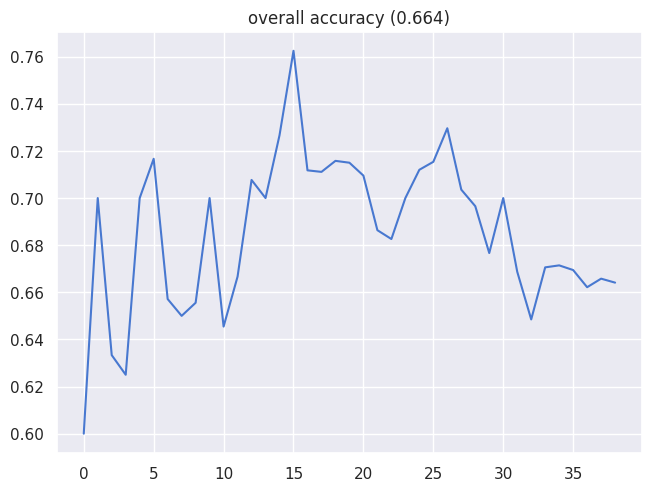

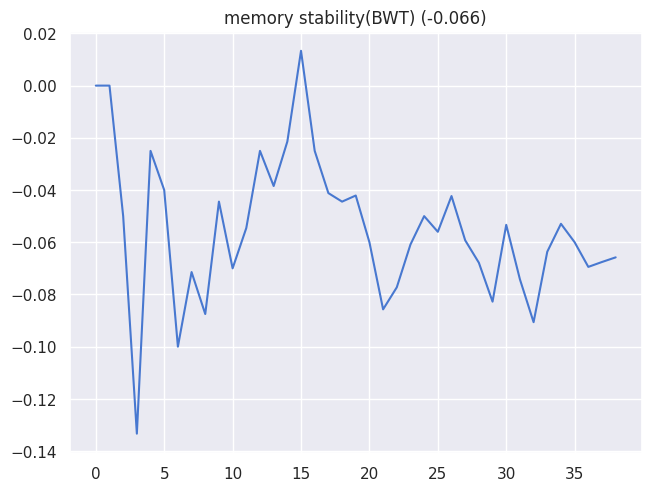

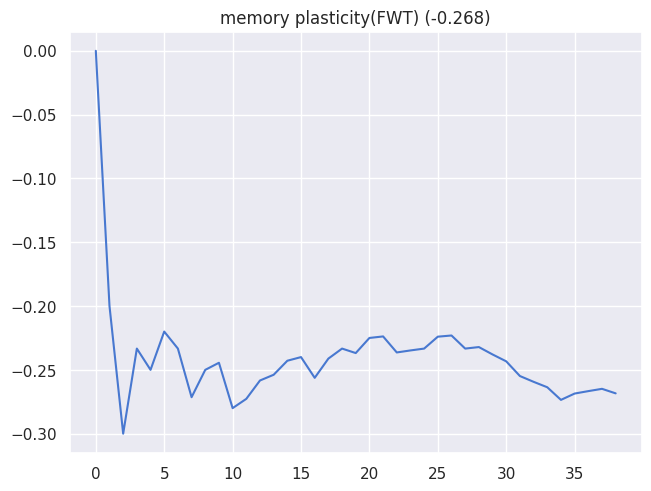

In [16]:
draw_statistic(overall_acc_list, mode='acc', title = "overall accuracy")
draw_statistic(memory_stability_list, mode='acc', title = "memory stability(BWT)")
draw_statistic(memory_plasticity_list, mode='acc', title = "memory plasticity(FWT)")

0.6 1.0
0.6 1.0
0.6 1.0
0.6 1.0
0.6 1.0
0.4 1.0
0.6 1.0
0.6 1.0
0.4 1.0
0.4 1.0
0.6 1.0
0.6 1.0
0.4 1.0
0.4 1.0
1.0 1.0
0.6 1.0
0.6 1.0
0.4 1.0
0.4 1.0
1.0 1.0
0.4 1.0
0.6 1.0
0.6 1.0
0.4 1.0
0.4 1.0
1.0 1.0
0.4 1.0
0.6 1.0
0.6 1.0
0.6 1.0
0.4 1.0
0.4 1.0
1.0 1.0
0.4 1.0
0.6 1.0
0.8 1.0
0.6 1.0
0.6 1.0
0.4 1.0
0.4 1.0
1.0 1.0
0.4 1.0
0.6 1.0
0.8 1.0
0.4 1.0
0.6 1.0
0.6 1.0
0.4 1.0
0.4 1.0
1.0 1.0
0.4 1.0
0.6 1.0
0.8 1.0
0.4 1.0
0.7 1.0
0.6 1.0
0.6 1.0
0.4 1.0
0.4 1.0
1.0 1.0
0.4 1.0
0.6 1.0
0.8 1.0
0.4 1.0
0.7 1.0
0.8 1.0
0.6 1.0
0.6 1.0
0.4 1.0
0.4 1.0
1.0 1.0
0.4 1.0
0.6 1.0
0.8 1.0
0.4 1.0
0.7 1.0
0.8 1.0
0.6 1.0
0.6 1.0
0.6 1.0
0.4 1.0
0.4 1.0
1.0 1.0
0.4 1.0
0.6 1.0
0.8 1.0
0.4 1.0
0.7 1.0
0.8 1.0
0.6 1.0
0.7 1.0
0.6 1.0
0.6 1.0
0.4 1.0
0.4 1.0
1.0 1.0
0.4 1.0
0.6 1.0
0.8 1.0
0.4 1.0
0.7 1.0
0.8 1.0
0.6 1.0
0.7 1.0
0.6 1.0
0.6 1.0
0.6 1.0
0.4 1.0
0.4 1.0
1.0 1.0
0.4 1.0
0.6 1.0
0.8 1.0
0.4 1.0
0.7 1.0
0.8 1.0
0.6 1.0
0.7 1.0
0.6 1.0
0.8 1.0
0.6 1.0
0.6 1.0
0.4 1.0
0.4 1.0
1.0 1.0


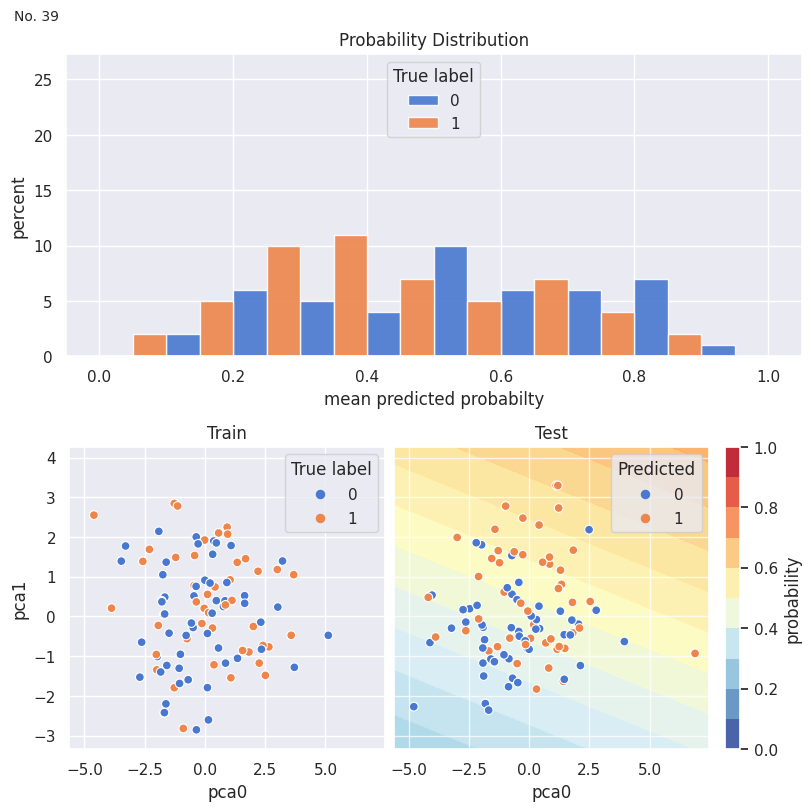

In [19]:
class Example6(PlotHelper):
    '''
    Update Method Steps:
    1. Selects a random subset of `sample` with a size of `train.size * 0.02`.
    2. Performs recourse on the selected samples.
    3. Randomly relabels samples based on the model's probability scores.
    4. Replaces a corresponding part of the training set with the updated samples.
    5. Refits the model with the modified training data.
    '''
    def update(self, model: nn.Module, train: Dataset, sample: Dataset):
        # sample is used for recourse training and train is used for main model triaing

        # sample size
        size = train.x.shape[0] // 10
        i = np.random.choice(sample.x.shape[0], size, False)
        x = sample.x[i]

        # find out some data whose label is 0 in sample to concatenate 1's data and 0's data
        sample_y_zero = np.where(sample.y == 0)[0]
        sample_0_indices = np.random.choice(sample_y_zero, size=size, replace=False)

        with pt.no_grad():
            y_prob: pt.Tensor = model(x)

        y_pred = y_prob.flatten() < 0.5
        sub_sample = Dataset(x[y_pred], pt.full((y_pred.count_nonzero(), 1), 0.6))

        recourse(model, sub_sample, 5, weight)

        x[y_pred] = sub_sample.x

        j = np.random.choice(train.x.shape[0], size, False)

        with pt.no_grad():
            y_prob: pt.Tensor = model(x)

        # randomly relabel
        train.x[j] = x
        train.y[j] = (pt.rand_like(y_prob) > y_prob).float()

        val_data = Dataset(train.x[j], train.y[j])
        validation_list.append(val_data)
        sample_model = LogisticRegression(val_data.x.shape[1], 1)
        sample_model.train()
        training(sample_model, val_data, 10)
        Aj_tide_list.append(calculate_accuracy(sample_model(val_data.x), val_data.y))

        model.train()
        training(model, train, 30)

        # calculate the overall accuracy
        overall_acc_list.append(calculate_AA(model, validation_list))

        # evaluate memory stability
        memory_stability_list.append(calculate_BWT(model, validation_list, Ajj_performance_list))

        # evaluate memory plasticity
        memory_plasticity_list.append(calculate_FWT(Ajj_performance_list, Aj_tide_list))


weight = pt.arange(1, train.x.shape[1] + 1)
# pt.randn(train.x.shape[1])
ex6 = Example6(model, pca, train, test, sample)
ani6 = ex6.animate_all(40)
ani6.save('output/ex6.gif')

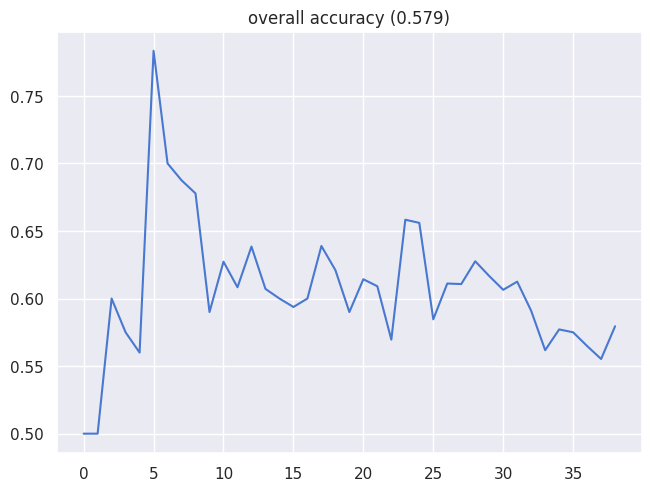

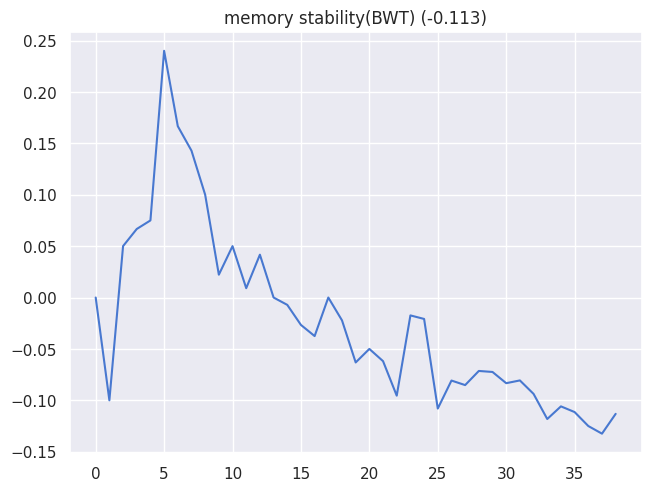

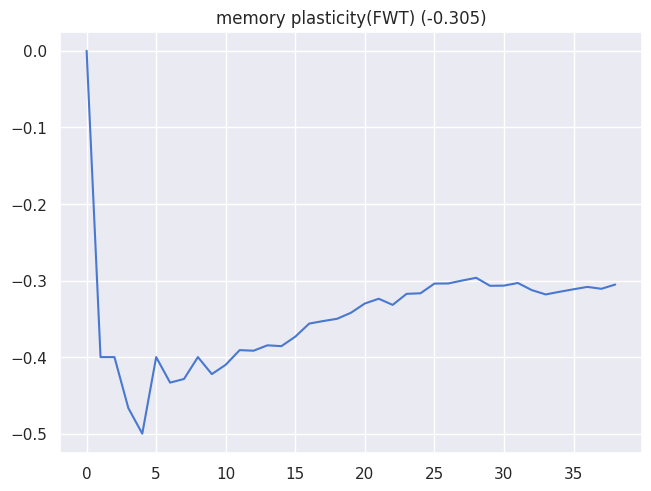

In [20]:
draw_statistic(overall_acc_list, mode='acc', title = "overall accuracy")
draw_statistic(memory_stability_list, mode='acc', title = "memory stability(BWT)")
draw_statistic(memory_plasticity_list, mode='acc', title = "memory plasticity(FWT)")